In [ ]:
import pandas as pd

indexes = []
all_indexes = {}

all_indexes = pd.read_excel('../Data/Index_Data.xlsx', sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170,-0.014103,0.017844,0.000030,-0.017502,11,2,2025
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606,-0.000225,0.014211,0.003563,-0.010498,12,2,2025
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422,-0.000815,0.009881,0.007394,-0.002463,13,2,2025
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624,-0.005888,0.013831,0.001231,-0.012428,14,2,2025
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759,0.004699,0.009924,0.005295,-0.004583,17,2,2025


In [ ]:
# !pip install prophet

In [ ]:
from prophet import Prophet
import numpy as np

In [ ]:
def create_feature(df, final_df):
    final_df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(window=14).mean() / df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))
    final_df['Daily_Range'] = df['High'] - df['Low']
    final_df['Close_Low_Ratio'] = (df['Close'] - df['Low']) / df['Low']
    final_df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    final_df['ATR'] = final_df['Daily_Range'].rolling(window=14).mean()
    final_df['Rolling_Std_Dev'] = df['Close'].rolling(window=14).std()

    return final_df

In [ ]:
new_df = pd.DataFrame()
new_df['Date'] = BSESN['Date']
new_df['Close'] = BSESN['Close']
df = create_feature(BSESN, new_df)

df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_localize(None)
df.dropna(inplace=True)
df.tail()

,Date,Close,RSI,Daily_Range,Close_Low_Ratio,MACD,ATR,Rolling_Std_Dev
6803,2025-02-11,76293.601562,49.247880,1356.687500,0.003459,-163.978442,779.252232,956.567186
6804,2025-02-12,76171.078125,47.643731,1071.328125,0.010382,-237.491591,817.102679,975.092398
6805,2025-02-13,76138.968750,49.638114,751.101562,0.001652,-294.942337,806.881138,978.468637
6806,2025-02-14,75939.210938,54.414854,1043.421875,0.006622,-352.527535,834.402344,914.995991
6807,2025-02-17,75996.859375,50.793814,747.203125,0.009325,-389.028000,824.196987,906.201408


In [ ]:
df.isna().sum()

,0
Date,0
Close,0
RSI,0
Daily_Range,0
Close_Low_Ratio,0
MACD,0
ATR,0
Rolling_Std_Dev,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6794 entries, 14 to 6807
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             6794 non-null   datetime64[ns]
 1   Close            6794 non-null   float64       
 2   RSI              6794 non-null   float64       
 3   Daily_Range      6794 non-null   float64       
 4   Close_Low_Ratio  6794 non-null   float64       
 5   MACD             6794 non-null   float64       
 6   ATR              6794 non-null   float64       
 7   Rolling_Std_Dev  6794 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 477.7 KB


In [ ]:
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df.tail()

,ds,y,RSI,Daily_Range,Close_Low_Ratio,MACD,ATR,Rolling_Std_Dev
6803,2025-02-11,76293.601562,49.247880,1356.687500,0.003459,-163.978442,779.252232,956.567186
6804,2025-02-12,76171.078125,47.643731,1071.328125,0.010382,-237.491591,817.102679,975.092398
6805,2025-02-13,76138.968750,49.638114,751.101562,0.001652,-294.942337,806.881138,978.468637
6806,2025-02-14,75939.210938,54.414854,1043.421875,0.006622,-352.527535,834.402344,914.995991
6807,2025-02-17,75996.859375,50.793814,747.203125,0.009325,-389.028000,824.196987,906.201408


In [ ]:
train = df[:-365]
test = df[-365:]

In [ ]:
train.shape, test.shape

((6429, 8), (365, 8))

In [ ]:
model = Prophet()
model.add_regressor('RSI', standardize=False)
model.add_regressor('Daily_Range', standardize=False)
model.add_regressor('Close_Low_Ratio', standardize=False)
model.add_regressor('MACD', standardize=False)
model.add_regressor('ATR', standardize=False)
model.add_regressor('Rolling_Std_Dev', standardize=False)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxh2akzly/tdu9q62s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxh2akzly/agsqlfs9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55208', 'data', 'file=/tmp/tmpxh2akzly/tdu9q62s.json', 'init=/tmp/tmpxh2akzly/agsqlfs9.json', 'output', 'file=/tmp/tmpxh2akzly/prophet_modelm_9vt6a3/prophet_model-20250330152428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=365)
future['RSI'] = df['RSI'].iloc[-1]
future['Daily_Range'] = df['Daily_Range'].iloc[-1]
future['Close_Low_Ratio'] = df['Close_Low_Ratio'].iloc[-1]
future['MACD'] = df['MACD'].iloc[-1]
future['ATR'] = df['ATR'].iloc[-1]
future['Rolling_Std_Dev'] = df['Rolling_Std_Dev'].iloc[-1]

forecast = model.predict(future)

In [ ]:
test_df = pd.DataFrame({"test":test['y']})
test_df = test_df.reset_index(drop=True)

predicted_df = pd.DataFrame({"forecast":forecast['yhat'][-365:]})
predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
comparison_df = pd.concat([test_df, predicted_df], axis=1)
comparison_df['difference'] = comparison_df['test'] - comparison_df['forecast']
comparison_df

,test,forecast,difference
0,65252.339844,58350.647030,6901.692813
1,64886.511719,58410.013777,6476.497942
2,64996.601562,60877.756775,4118.844788
3,65075.820312,60896.444551,4179.375761
4,65087.250000,58596.738333,6490.511667
...,...,...,...
360,76293.601562,64929.629803,11363.971760
361,76171.078125,62620.282027,13550.796098
362,76138.968750,62465.541915,13673.426835
363,75939.210938,62587.700346,13351.510592


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(comparison_df['test'], comparison_df['forecast'])

print(f"MAE: {mae}")

MAE: 13713.673201646454
MSE: 212886052.36724117
R-squared: -5.658274075479622


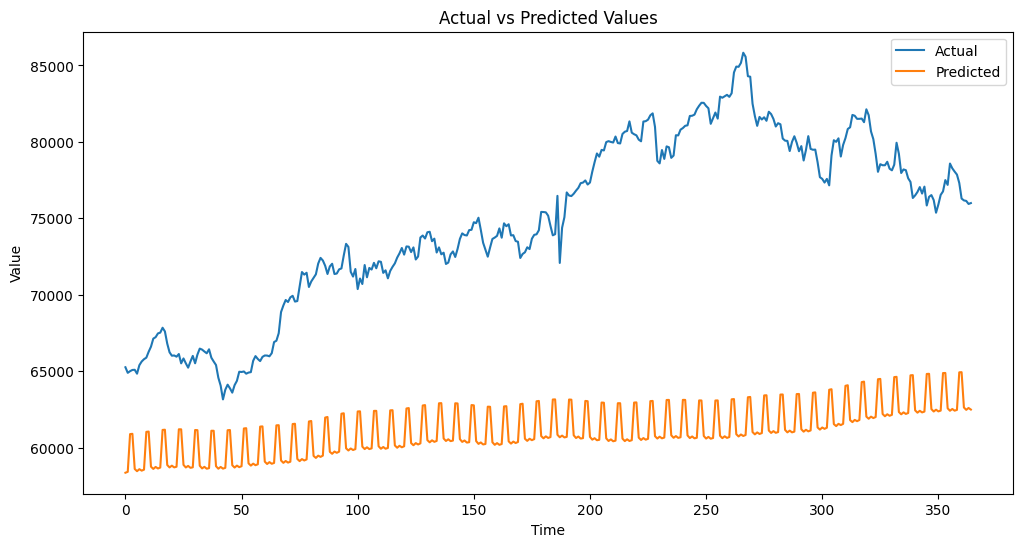

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['test'], label='Actual')
plt.plot(comparison_df['forecast'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()